In [21]:
import os
import sys
project_root = '/Users/viskawei/Desktop/VIT/src'
sys.path.insert(0, str(project_root)) 
PCA_DIR = os.environ.get('PCA_DIR', '.')

In [ ]:
pca_U = torch.load("/Users/viskawei/Desktop/VIT/data/pca.pt")

In [2]:
PCA_DIR

'$DATA_ROOT/pca'

In [1]:
import torch
# kpca = torch.load(os.path.join(PCA_DIR, 'kpca_state.pt'))
kpca = torch.load("/Users/viskawei/Desktop/VIT/data/pca/kpca_state.pt")
# pca = torch.load("/Users/viskawei/Desktop/VIT/data/pca/pca_4096.pt", weights_only=True)

In [2]:
kpca.keys()

dict_keys(['landmarks', 'A', 'row_means', 'K_mean', 'kernel_name', 'gamma', 'degree', 'coef0', 'r'])

In [3]:
kpca['A'].shape

torch.Size([1000, 1000])

In [16]:
kpca['K_mean']

0.4041983485221863

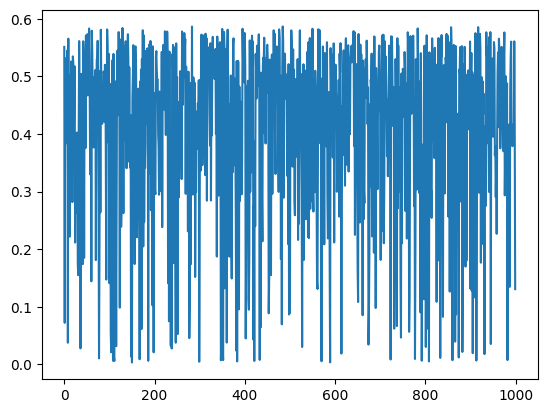

In [15]:
import matplotlib.pyplot as plt
plt.plot(kpca['row_means'])
# plt.plot(kpca['A'][:, :10])

In [11]:
kpca['row_means'].shape

torch.Size([1000])

In [7]:
pca_U["S"].shape

torch.Size([4096])

In [8]:
pca_U["U"].shape

torch.Size([100000, 4096])

In [10]:
torch.save(
    {
        "U": pca_U["U"][:4096],  # Take first 32 components
        "S": pca_U["S"],
        "Vt": pca_U["Vt"],
    }, "/Users/viskawei/Desktop/VIT/evals/pca_4096.pt")

In [5]:
pca_U["U"].shape

torch.Size([100000, 4096])

In [8]:
pca_U.shape


torch.Size([32, 4096])

In [7]:
pca['Vt'].shape

torch.Size([4096, 4096])

In [9]:
pca['U'][:1000].shape

torch.Size([1000, 4096])

In [ ]:
# torch.save(pca['U'][:32], "/Users/viskawei/Desktop/VIT/evals/pca_U_32.pt")
# torch.save(pca['U'][:512], "/Users/viskawei/Desktop/VIT/evals/pca_U_512.pt")


In [ ]:
# PCP truncated to 50
# ViT on spectra, input: noisy spectra -> Teff/[M/H]
# Weights, attention map
# whether quantization shows up in ViT
# Correspondence between attention map and PCA/PCP
 # fix weights with PCA. Can we shortcut NN training with PCA
# check time to train ViT PCA or PCP.


In [1]:
import os
# dir_path = '/datascope/subaru/user/swei20/data/bosz50000'
# file_path = os.path.join(dir_path, 'z0', 'train_100k' , 'dataset.h5')
file_path = '/Users/viskawei/Desktop/VIT/data/test_1k/dataset.h5'
import pandas as pd
a= pd.read_hdf(file_path)
num_samples = 100000
a = a[:num_samples]
a.head()

,id,redshift,redshift_err,exp_count,exp_time,seeing,ext,target_zenith_angle,target_field_angle,moon_zenith_angle,...,O_M,O_M_err,T_eff,T_eff_err,log_g,log_g_err,N_He,v_turb,L_H,interp_param
0,0,0.0,0.0,12,900.0,1.070516,NaN,16.040771,0.429334,84.553118,...,NaN,NaN,5484.222145,NaN,2.000000,NaN,NaN,NaN,NaN,T_eff
1,1,0.0,0.0,12,900.0,1.248321,NaN,2.530205,0.166963,43.735394,...,NaN,NaN,4000.000000,NaN,1.000000,NaN,NaN,NaN,NaN,a_M
2,2,0.0,0.0,12,900.0,1.112737,NaN,22.432774,0.096839,35.778106,...,NaN,NaN,4500.000000,NaN,3.500000,NaN,NaN,NaN,NaN,M_H
3,3,0.0,0.0,12,900.0,1.192399,NaN,22.205080,0.347952,59.688280,...,NaN,NaN,5750.000000,NaN,2.054143,NaN,NaN,NaN,NaN,log_g
4,4,0.0,0.0,12,900.0,0.677280,NaN,37.922405,0.630086,61.514009,...,NaN,NaN,5000.000000,NaN,2.000000,NaN,NaN,NaN,NaN,M_H


In [2]:
import h5py
import torch
with h5py.File(file_path, 'r') as f:
    wave = torch.Tensor(f['spectrumdataset/wave'][()])
    flux = torch.Tensor(f['dataset/arrays/flux/value'][:num_samples])
    # error = torch.Tensor(f['dataset/arrays/error/value'][:num_samples])

In [6]:

import numpy as np
from typing import Tuple, Dict, Any, Optional

try:
    from sklearn.utils.extmath import randomized_svd
    _HAS_SK = True
except Exception:
    _HAS_SK = False


def soft_threshold(X: np.ndarray, tau: float) -> np.ndarray:
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0.0)


def svt_full(M: np.ndarray, tau: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    U, s, Vt = np.linalg.svd(M, full_matrices=False)
    s_thresh = np.maximum(s - tau, 0.0)
    return U, s_thresh, Vt


def svt_randomized(
    M: np.ndarray,
    tau: float,
    n_components: int,
    oversampling: int = 10,
    power_iter: int = 2,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if not _HAS_SK:
        return svt_full(M, tau)
    n_components = max(1, int(n_components))
    U, s, Vt = randomized_svd(
        M,
        n_components=n_components,
        n_oversamples=oversampling,
        n_iter=power_iter,
        transpose='auto',
        random_state=None,
    )
    s_thresh = np.maximum(s - tau, 0.0)
    nz = s_thresh > 0
    return U[:, nz], s_thresh[nz], Vt[nz, :]


def reconstruct_from_svd(U: np.ndarray, s: np.ndarray, Vt: np.ndarray) -> np.ndarray:
    if s.size == 0:
        return np.zeros((U.shape[0], Vt.shape[1]), dtype=U.dtype)
    return (U * s) @ Vt


def pcp(
    D: np.ndarray,
    lambda_: Optional[float] = None,
    mu: Optional[float] = None,
    tol: float = 1e-7,
    max_iter: int = 1000,
    svd: str = "randomized",
    rank_guess: int = 50,
    oversampling: int = 10,
    power_iter: int = 2,
    dtype: str = "float32",
    verbose: bool = True,
) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
    D = np.asarray(D, dtype=dtype, order='C')
    n, m = D.shape
    normD = np.linalg.norm(D, ord='fro')
    if lambda_ is None:
        lambda_ = 1.0 / np.sqrt(max(n, m))
    L = np.zeros_like(D)
    S = np.zeros_like(D)
    Y = np.zeros_like(D)
    if mu is None:
        x = np.random.randn(m).astype(D.dtype)
        for _ in range(5):
            x = D.T @ (D @ x)
            x_norm = np.linalg.norm(x) + 1e-12
            x /= x_norm
        spectral = np.sqrt(np.linalg.norm(D @ x))
        mu = 1.25 / (spectral + 1e-12)
    mu_bar = mu * 1e7
    rho = 1.5
    history = {"primal_resid": [], "dual_resid": [], "rank": [], "nnz": [], "iters": 0}
    for k in range(1, max_iter + 1):
        M = D - S + (1.0 / mu) * Y
        if svd == "full":
            U, s, Vt = svt_full(M, 1.0 / mu)
        else:
            U, s, Vt = svt_randomized(M, 1.0 / mu, n_components=rank_guess, oversampling=oversampling, power_iter=power_iter)
        L = reconstruct_from_svd(U, s, Vt)
        r = D - L + (1.0 / mu) * Y
        S = soft_threshold(r, lambda_ / mu)
        R = D - L - S
        Y = Y + mu * R
        primal_resid = np.linalg.norm(R, ord='fro') / (normD + 1e-12)
        rank = int((s > 0).sum())
        nnz = int((np.abs(S) > 0).sum())
        history["primal_resid"].append(float(primal_resid))
        history["rank"].append(rank)
        history["nnz"].append(nnz)
        history["iters"] = k
        if verbose and (k % 10 == 0 or primal_resid < tol):
            print(f"[PCP] iter={k:4d}  resid={primal_resid:.3e}  rank(L)={rank}  nnz(S)={nnz}  mu={mu:.3e}")
        if primal_resid < tol:
            break
        mu = min(mu * rho, mu_bar)
    return L, S, history


In [ ]:
import numpy as np
# from prepca.robust_pcp import pcp
# from robust_pcp import pcp
# 假设 X 的形状是 (100_000, 4096)，float32 更省内存
# X = np.memmap('spectra.dat', dtype='float32', mode='r', shape=(100_000, 4096))  # 如需内存映射
# 或者如果已在内存中：
# X = X.astype('float32', copy=False)

L, S, hist = pcp(
    flux.numpy(),            # 输入数据矩阵
    svd='randomized',        # 使用随机化SVD，适合大矩阵
    rank_guess=32,          # 低秩的一个合理猜测（可调）
    oversampling=50,         # 随机化SVD过采样
    power_iter=35,            # 随机化SVD幂迭代以提高精度
    tol=1e-5,                # 收敛阈值（可放宽以提速）
    max_iter=1000,
    dtype='float32',         # 内部计算用 float32 减内存
    verbose=True
)

# L: 低秩（主成分子空间重构）
# S: 稀疏（异常/强发射线/坏像素等）
# hist: 日志与收敛信息（残差、rank、nnz 等）
print(hist['iters'], hist['primal_resid'][-1], hist['rank'][-1])

[PCP] iter=  10  resid=9.268e-04  rank(L)=32  nnz(S)=53385  mu=1.511e+00
[PCP] iter=  20  resid=4.793e-05  rank(L)=32  nnz(S)=2474599  mu=8.712e+01
[PCP] iter=  24  resid=6.003e-06  rank(L)=32  nnz(S)=3595313  mu=4.411e+02
24 6.002941414902599e-06 32


In [23]:
L.shape, S.shape

((1000, 4096), (1000, 4096))

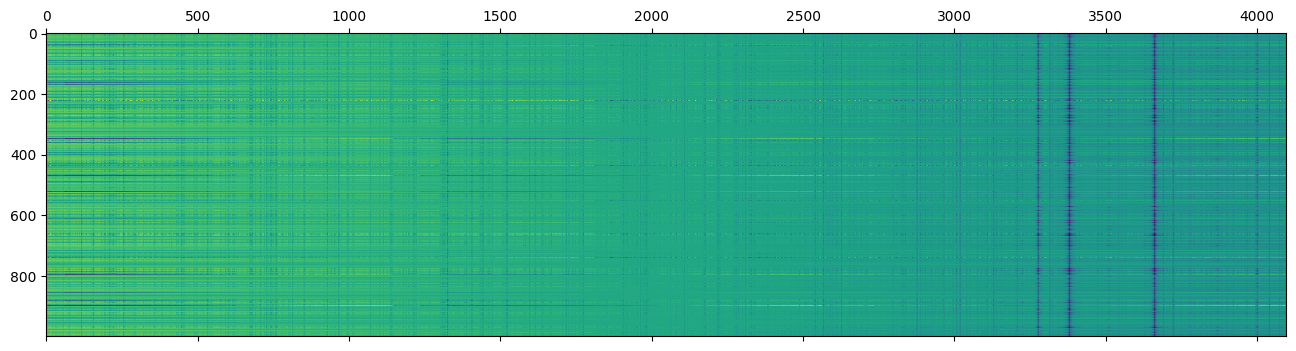

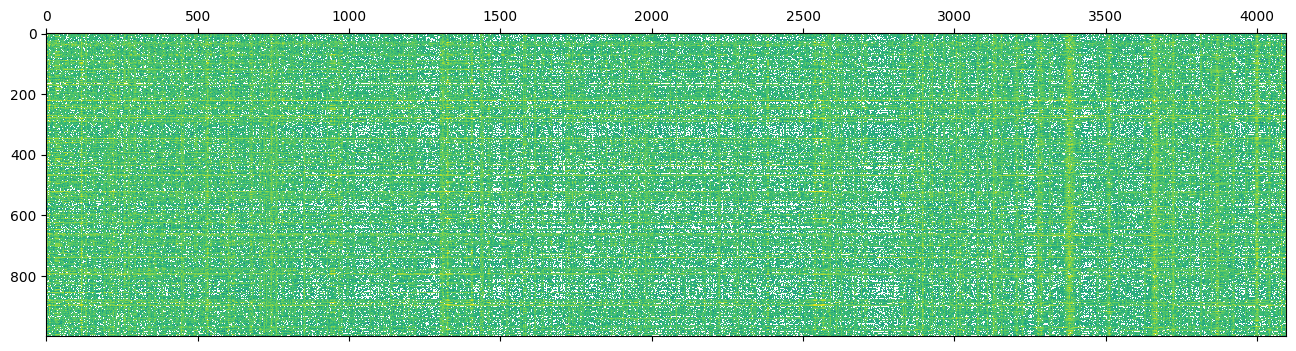

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.matshow(L, aspect='auto', cmap='viridis')
plt.matshow(abs(S), aspect='auto', cmap='viridis', norm=LogNorm())

In [18]:
S.min(), S.max()    , L.min(), L.max()

(np.float64(-0.085379857542108),
 np.float64(0.06865751787984849),
 np.float64(0.08889820869054682),
 np.float64(0.7859866885673337))

In [3]:
flux.min(), flux.shape

(tensor(0.0483), torch.Size([100000, 4096]))

In [4]:
X = flux.clip(min=0.0)
X_mean = torch.mean(X, dim=0)
X_mean.shape

torch.Size([4096])

In [5]:
X = X - X_mean
U, S, Vt = torch.linalg.svd(X, full_matrices=False)
U.shape, S.shape, Vt.shape

(torch.Size([100000, 4096]), torch.Size([4096]), torch.Size([4096, 4096]))

In [13]:
torch.save({'U': U, 'S': S, 'Vt': Vt, 'proj':projected}, 'pca.pt')

In [ ]:
np.savez('pca.npz', U=U.numpy(), S=S.numpy(), Vt=Vt.numpy())

In [10]:
k= 4096
components = Vt[:k, :].T
projected = X @ components
projected.shape

torch.Size([100000, 4096])

In [9]:
U[0]

tensor([-0.0010, -0.0023, -0.0011,  ..., -0.0019, -0.0008, -0.0012])

In [11]:
projected[0]

tensor([-4.7954e-01, -4.8515e-01, -2.0470e-01,  ...,  3.0523e-09,
         1.7686e-08, -7.8689e-09])

In [8]:
import pandas as pd
K = 10
df = pd.DataFrame(projected[:, :K], columns=[f'PC{i}' for i in range(K)])
df['M_H'] = a['M_H'].values[:num_samples]
df['T_eff'] =  a['T_eff'].values[:num_samples]
df['log_g'] =  a['log_g'].values

In [9]:
import plotly.express as px
ii = 0
fig = px.scatter_3d(df, x=f'PC{ii}', y=f'PC{ii+1}', z=f'PC{ii+2}', color='T_eff', color_continuous_scale='RdBu')
fig.update_traces(marker=dict(size=2))
fig.write_html("Teff_3d_plot.html")  # ✅ saves interactive HTML file
# Then manually open 3d_plot.html in your browser

In [10]:
import plotly.express as px
ii = 2
fig = px.scatter_3d(df, x=f'PC{ii}', y=f'PC{ii+1}', z=f'PC{ii+2}', color='T_eff', color_continuous_scale='viridis')
fig.update_traces(marker=dict(size=2))
fig.write_html("logg_3d_plot.html") 

ValueError: 'c' argument has 100 elements, which is inconsistent with 'x' and 'y' with size 100000.

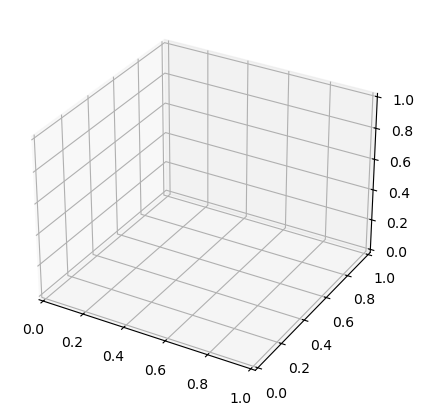

In [11]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2],
                c=a['M_H'].values[:100], cmap='BrBG', s=1)

ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
cb = fig.colorbar(sc, ax=ax, shrink=0.5)
cb.set_label('[M/H]')
# plt.title('3D Interactive Scatter Plot')



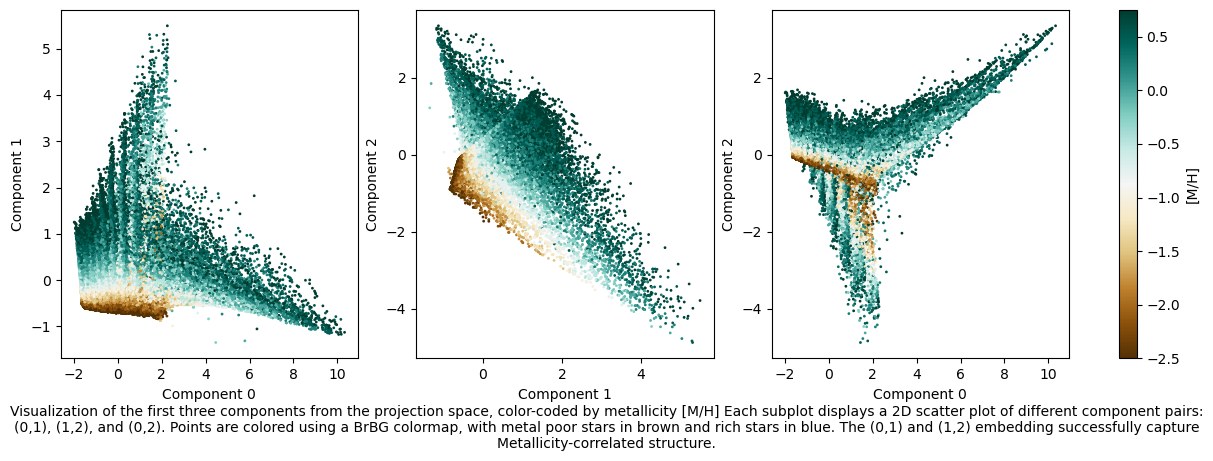

In [ ]:
import matplotlib.pyplot as plt

pairs = [(0, 1), (1, 2), (0, 2)]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

for ax, (i, j) in zip(axs, pairs):
    sc = ax.scatter(projected[:, i], projected[:, j], s=1, c=a['M_H'].values, cmap='BrBG')
    ax.set_xlabel(f'Component {i}')
    ax.set_ylabel(f'Component {j}')
caption = ("Visualization of the first three components from the projection space, "
           "color-coded by metallicity [M/H] "
           "Each subplot displays a 2D scatter plot of different component pairs: "
           "(0,1), (1,2), and (0,2). Points are colored using a BrBG colormap, "
           "with metal poor stars in brown and rich stars in blue-green. The (0,1) and (1,2) embedding successfully capture "
           "Metallicity-correlated structure.")

plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

fig.colorbar(sc, ax=axs, location='right', label='[M/H]')

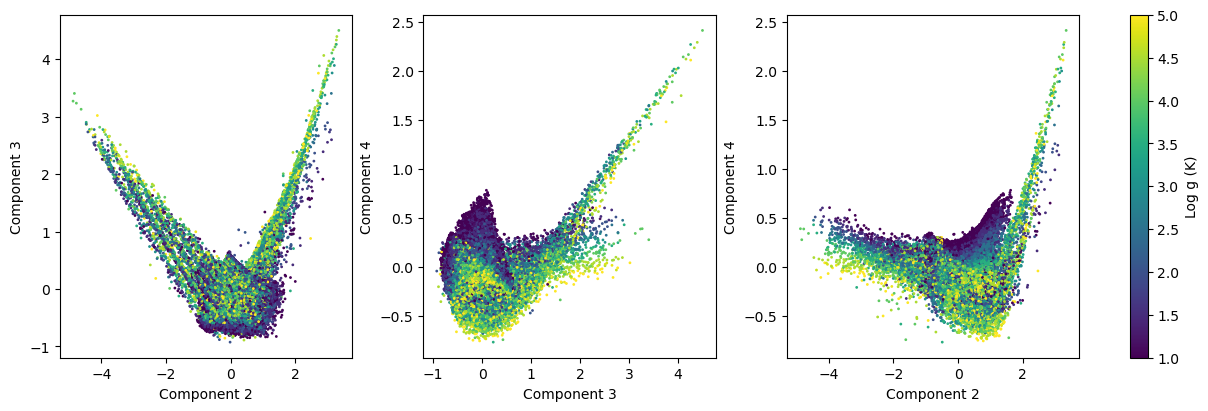

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
ii = 2
pairs = [(ii, ii+1), (ii+1, ii+2), (ii, ii+2)]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

for ax, (i, j) in zip(axs, pairs):
    sc = ax.scatter(projected[:, i], projected[:, j], s=1, c=a['log_g'].values, cmap='viridis')
    ax.set_xlabel(f'Component {i}')
    ax.set_ylabel(f'Component {j}')
    # ax.set_title(f'{i} vs {j}')
# caption = ("Visualization of the first three components from the projection space, "
#            "color-coded by gravity (log g) "
#            "Each subplot displays a 2D scatter plot of different component pairs: "
#            "(0,1), (1,2), and (0,2). Points are colored using a red-blue colormap, "
#            "with cooler stars in red and hotter stars in blue. The embedding captures "
#            "temperature-correlated structure, indicating that the projection retains "
#            "astrophysically meaningful information.")
# plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

fig.colorbar(sc, ax=axs, location='right', label='Log g (K)')
fig.show()

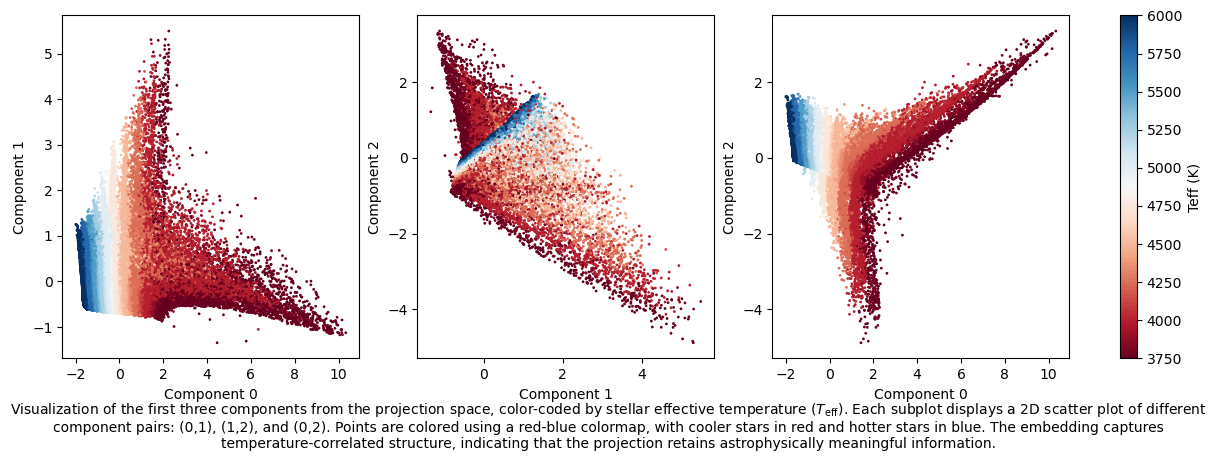

In [82]:
import matplotlib.pyplot as plt

pairs = [(0, 1), (1, 2), (0, 2)]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

for ax, (i, j) in zip(axs, pairs):
    sc = ax.scatter(projected[:, i], projected[:, j], s=1, c=a['T_eff'].values, cmap='RdBu')
    ax.set_xlabel(f'Component {i}')
    ax.set_ylabel(f'Component {j}')
    # ax.set_title(f'{i} vs {j}')
caption = ("Visualization of the first three components from the projection space, "
           "color-coded by stellar effective temperature ($T_\\mathrm{eff}$). "
           "Each subplot displays a 2D scatter plot of different component pairs: "
           "(0,1), (1,2), and (0,2). Points are colored using a red-blue colormap, "
           "with cooler stars in red and hotter stars in blue. The embedding captures "
           "temperature-correlated structure, indicating that the projection retains "
           "astrophysically meaningful information.")

plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

fig.colorbar(sc, ax=axs, location='right', label='Teff (K)')

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def plot_svd_s(SSList, labels = None, ax=None):
    if ax is None: f, ax = plt.subplots(1, 1, facecolor='w')
    if labels is None: labels = np.arange(len(SSList))
    colors = ['k', 'r','orange','g','b','purple']
    for ii, ss in enumerate(SSList):
        ss0 = ss / torch.sum(ss) 
        ax.plot(np.arange(len(ss0)), ss0, 'o-',label = labels[ii], color=colors[ii], ms=2, lw=0.8)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_ylabel('Log Singular Value Ratio')
    ax.set_xlabel('Log Rank')    

    if labels is not None: ax.legend()

(0.0, 4096.0)

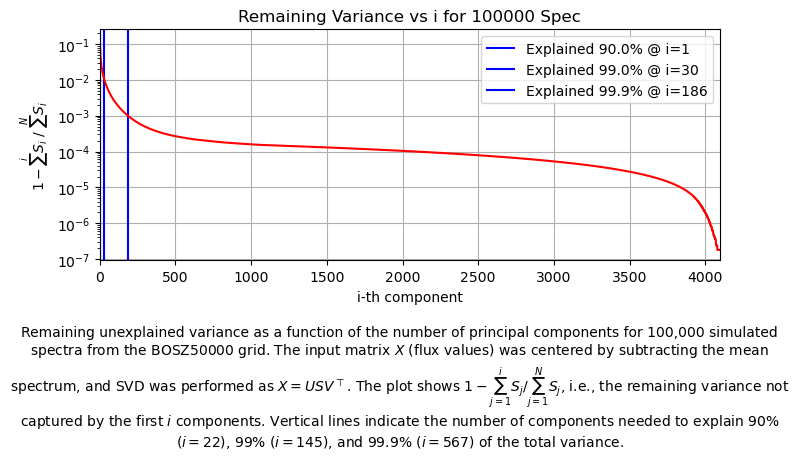

In [13]:
f = plt.figure(figsize=(8,3))
Sratio = 1 - torch.cumsum(S, dim=0) / torch.sum(S)
for i in range(1, 4):
    ratio = 10 ** (-i)
    idx = torch.argmin(torch.abs(Sratio - ratio))
    plt.axvline(idx, color='b', label=f'Explained {100 -100*ratio}% @ i={idx}')
plt.plot(Sratio, 'r-', ms=1)
plt.yscale('log')
plt.grid()
plt.legend()
plt.ylabel(r'$1 - \sum^i S_i$ / $\sum^N S_i $')
plt.xlabel('i-th component')
plt.title(f'Remaining Variance vs i for {num_samples} Spec')
caption=r'Remaining unexplained variance as a function of the number of principal components for 100,000 simulated spectra from the BOSZ50000 grid. The input matrix $X$ (flux values) was centered by subtracting the mean spectrum, and SVD was performed as $X = USV^\top$. The plot shows $1 - \sum_{j=1}^i S_j / \sum_{j=1}^N S_j$, i.e., the remaining variance not captured by the first $i$ components. Vertical lines indicate the number of components needed to explain 90% ($i=22$), 99% ($i=145$), and 99.9% ($i=567$) of the total variance.'
plt.figtext(0.5, -0.5, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.xlim(-0,4096)

In [16]:
Vt[:10].shape

torch.Size([10, 4096])

In [41]:
def air_to_vac(wave):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wave * 1e5
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wave


In [42]:
air_to_vac(8498)

8500.444156519

Text(0.5, 0.95, 'Top 10 Eigenspectrums $V_i$ with explained variance in %. The Ca II triplet, Na lines and TiO1,TiO2 lines are shown in red, orange, and blue.')

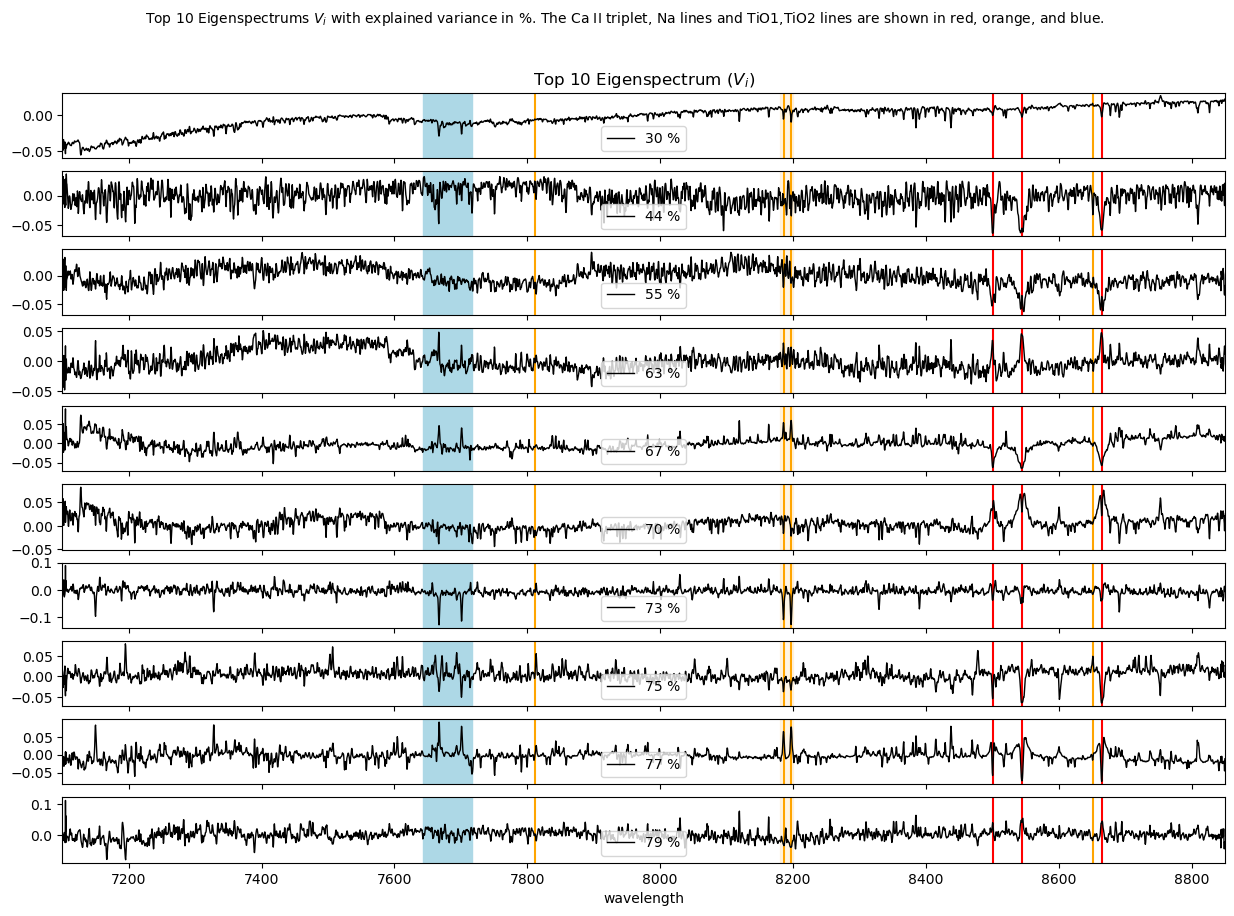

In [110]:
K = 10
ratios = 100 * torch.cumsum(S, dim=0) / torch.sum(S)
f, axes = plt.subplots(K, 1, figsize=(15, 10), sharex=True)
axes[-1].set(xlim=(wave[0], wave[-1]), xlabel='wavelength')
for i in range(K):
    for ca in [8498, 8542, 8662,]:
        axes[i].axvline(air_to_vac(ca), color='red')
    for na in [8183.255, 8194.8, 8649, 7810]:
        axes[i].axvline(air_to_vac(na), color='orange')
    # axes[i].axvline(8183.255, color='y')
    axes[i].axvspan(7643.25, 7717.25, color='lightblue')
    axes[i].axvspan(8180,8200, color='orange', alpha=0.1)

    axes[i].plot(wave, Vt[i], c='k',lw=1, label=f'{ratios[i]:.0f} %')
    axes[i].legend(loc='lower center')


axes[0].set_title(fr'Top {K} Eigenspectrum ($V_i$)')
caption=r'Top 10 Eigenspectrums $V_i$ with explained variance in %. The Ca II triplet, Na lines and TiO1,TiO2 lines are shown in red, orange, and blue.'
plt.figtext(0.5, 0.95, caption, wrap=True, horizontalalignment='center', fontsize=10)